# Setups

In [1]:
import os
import time
import sys

import numpy as np
import pandas
from skimage import io, transform
import matplotlib.pyplot as plt
import tifffile

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torch.cuda.amp import autocast
import albumentations as Alb
from skimage import transform

# Config

In [2]:
class CFG:
    """
    Configuration class for the blood vessel segmentation project.
    """

    # ============== Model Configuration =============
    MODEL_NAME = 'Unet'
    BACKBONE = 'se_resnext50_32x4d'
    IN_CHANNEL = 1  # Number of input channels (e.g., 1 for grayscale images)
    OUT_CHANNEL = 1 # Number of output channels

    # ============== Image Processing Settings =============
    INPUT_IMAGE_SIZE = (1024, 1024)  # Size of the input images (height x width)
    
    # =============
    # = Training and Validation Parameters =============
    VALID_ID = 1  # ID for validation dataset or fold
    BATCH_SIZE = 16  # Batch size for model training
    THRESHOLD_PERCENTILE = 0.0014109  # Threshold for post-processing
    LEARNING_RATE = 1e-4
    NUM_EPOCHS = 50
    NUM_WORKERS = 0 # Number of threads

    # ============== Model Paths =============
    # List of paths to trained model weights
    MODEL_PATHS = [
        "/path/to/model1.pt",
        "/path/to/model2.pt",
        # Add more model paths as needed
    ]

    # ============== Data Paths =============
    DATASET_NAME = "kidney_1_dense"
    DATASET_DIRECTORY = os.path.join("..", "blood-vessel-segmentation")
    TRAIN_DATASET_DIRECTORY = os.path.join(DATASET_DIRECTORY, "train", DATASET_NAME)
    TEST_DATASET_DIRECTORY = os.path.join(DATASET_DIRECTORY, "test", DATASET_NAME)

## Custom Dataset Class

In [4]:
class CustomDataset(Dataset):
    def __init__(self, image_path, target_image_size):
        self.image_path = image_path
        self.target_image_size = target_image_size
        self.image_filenames = sorted([os.path.join(image_path, filename) for filename in os.listdir(image_path) if filename.endswith('.tif')])
        print(f"{len(self.image_filenames)} samples are loaded.")

    def __getitem__(self, index):
        # Load image
        image = io.imread(self.image_filenames[index])

        # Resize and pad the image
        image = self.resize_and_pad(image, self.target_image_size)

        # Extract the filename
        image_filename = os.path.basename(self.image_filenames[index])
        return image, image_filename

    def __len__(self):
        return len(self.image_filenames)

    def resize_and_pad(self, image, target_image_size):
        """Resize an image and add padding to keep aspect ratio."""
        # Calculate scale and padding
        h, w = image.shape[:2]
        scale = min(target_image_size[0] / h, target_image_size[1] / w)
        new_h, new_w = int(h * scale), int(w * scale)
        pad_h = (target_image_size[0] - new_h) // 2
        pad_w = (target_image_size[1] - new_w) // 2

        # Resize image
        image_resized = transform.resize(image, (new_h, new_w), anti_aliasing=True)

        # Initialize padded image
        if len(image.shape) == 2:  # Grayscale image
            padded_image = np.zeros((target_image_size[0], target_image_size[1]), dtype=image_resized.dtype)
        else:
            padded_image = np.zeros((target_image_size[0], target_image_size[1], image.shape[2]), dtype=image_resized.dtype)

        # Insert the resized image
        padded_image[pad_h:pad_h+new_h, pad_w:pad_w+new_w] = image_resized

        return padded_image

In [5]:
def display_image(image, title):
    # If the input is a PyTorch tensor
    if isinstance(image, torch.Tensor):
        if len(image.shape) == 4:
            image = image.squeeze(0)

        numpy_image = image.cpu().numpy()

        if len(numpy_image.shape) == 3 and numpy_image.shape[0] == 1:
            numpy_image = numpy_image.squeeze(0)

        if len(numpy_image.shape) == 3:
            numpy_image = numpy_image.transpose(1, 2, 0)

    # If the input is a NumPy array
    elif isinstance(image, np.ndarray):
        numpy_image = image

        if len(numpy_image.shape) == 3 and numpy_image.shape[0] == 1:
            numpy_image = numpy_image.squeeze(0)
    
        plt.imshow(numpy_image, cmap='gray')
        plt.title(title)
        plt.axis('off')
        plt.show()

In [6]:
image_path = os.path.join(CFG.TRAIN_DATASET_DIRECTORY, "images")
mask_path = os.path.join(CFG.TRAIN_DATASET_DIRECTORY, "labels")
image_dataset = CustomDataset(image_path, CFG.INPUT_IMAGE_SIZE)
mask_dataset = CustomDataset(mask_path, CFG.INPUT_IMAGE_SIZE)
print(image_dataset[0][0].shape)
display_image(image_dataset[900][0], "t")

FileNotFoundError: [WinError 3] 지정된 경로를 찾을 수 없습니다: '..\\blood-vessel-segmentation\\train\\kidney_1_dense\\images'

# tensor image

In [ ]:
data_set = 'kidney_2'

image_path = os.path.join('..', 'data', 'train', data_set, 'images')
label_path = os.path.join('..', 'data', 'train', data_set, 'labels')

image_files = sorted([os.path.join(image_path, f) for f in os.listdir(image_path) if f.endswith('.tif')])
label_files = sorted([os.path.join(label_path, f) for f in os.listdir(label_path) if f.endswith('.tif')])

def display_image(tensor):
    if isinstance(tensor, torch.Tensor):
        # If the input is a PyTorch tensor
        if len(tensor.shape) == 4:
            tensor = tensor.squeeze(0)

        numpy_image = tensor.cpu().numpy()

        if len(numpy_image.shape) == 3 and numpy_image.shape[0] == 1:
            numpy_image = numpy_image.squeeze(0)

        if len(numpy_image.shape) == 3:
            numpy_image = numpy_image.transpose(1, 2, 0)

    elif isinstance(tensor, np.ndarray):
        # If the input is a NumPy array
        numpy_image = tensor

        if len(numpy_image.shape) == 3 and numpy_image.shape[0] == 1:
            numpy_image = numpy_image.squeeze(0)
    
    plt.imshow(numpy_image, cmap='gray')
    plt.axis('off')
    plt.show()

True True


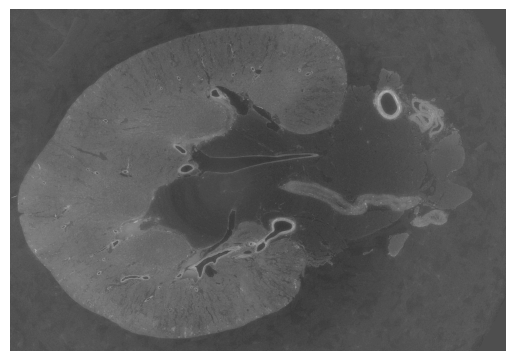

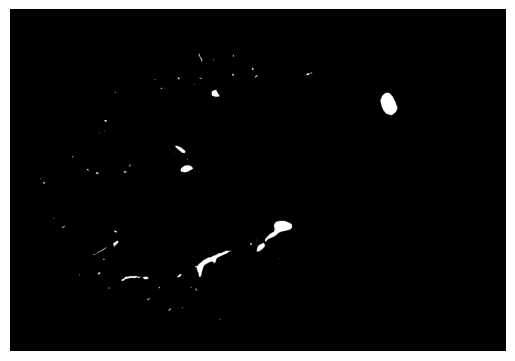

True True


In [13]:

first_image = tifffile.imread(image_files[981])
first_label = tifffile.imread(label_files[981])

is_image = isinstance(first_image, np.ndarray)
is_mask = isinstance(first_label, np.ndarray)
print(is_image, is_mask)

# Convert tensor floats32
first_image_tensor = torch.from_numpy(first_image.astype(np.float32))
first_label_tensor = torch.from_numpy(first_label.astype(np.float32))

display_image(first_image_tensor)
display_image(first_label_tensor)

is_image_tensor = isinstance(first_image_tensor, torch.Tensor)
is_mask_tensor = isinstance(first_label_tensor, torch.Tensor)
print(is_image_tensor, is_mask_tensor)

# 0.1 Image Augmentation

In [ ]:
def Augement_image(image, mask):

    image_dense = torch.from_numpy(image.astype(np.float32))
    mask_dense = torch.from_numpy(mask.astype(np.float32))

    if len(image_dense.shape) == 2:
        image_dense = image_dense.unsqueeze(0)

    image_np = image_dense.permute(1, 2, 0).numpy()
    mask_np = mask_dense.numpy()

    image_list = [None, None, None, None]
    mask_list = [None, None, None, None]
    
    transform_rotate_90 = Alb.Compose([
        Alb.Rotate(limit=90, p=0.5)
    ])

    # Original image
    image_list[0] = image_np
    mask_list[0] = mask_np

    # Original image with 90-degree rotation
    augmented_rotate_90 = transform_rotate_90(image=image_np, mask=mask_np)
    image_list[1], mask_list[1] = augmented_rotate_90['image'], augmented_rotate_90['mask']

    # Original image with 180-degree rotation
    augmented_rotate_180 = transform_rotate_90(image=image_list[1], mask=mask_list[1])   
    image_list[2], mask_list[2] = augmented_rotate_180['image'], augmented_rotate_180['mask']

    # Original image with 270-degree rotation
    augmented_rotate_270 = transform_rotate_90(image=image_list[2], mask=mask_list[2])
    image_list[3], mask_list[3] = augmented_rotate_270['image'], augmented_rotate_270['mask']

    # Making the mask dimentions 3
    for i in range(4):
        if mask_list[i].ndim == 2:
            mask_list[i] = mask_list[i][..., np.newaxis]

    augmented_data_zip = list(zip(*[image_list, mask_list]))

    return augmented_data_zip

[(array([[[34092.],
        [32989.],
        [33755.],
        ...,
        [32768.],
        [32768.],
        [32768.]],

       [[33363.],
        [32322.],
        [33004.],
        ...,
        [32768.],
        [32768.],
        [32768.]],

       [[33308.],
        [33045.],
        [32822.],
        ...,
        [32768.],
        [32768.],
        [32768.]],

       ...,

       [[32314.],
        [33162.],
        [32016.],
        ...,
        [32768.],
        [32768.],
        [32768.]],

       [[32913.],
        [32751.],
        [32995.],
        ...,
        [32768.],
        [32768.],
        [32768.]],

       [[32938.],
        [33945.],
        [33908.],
        ...,
        [32768.],
        [32768.],
        [32768.]]], dtype=float32), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 

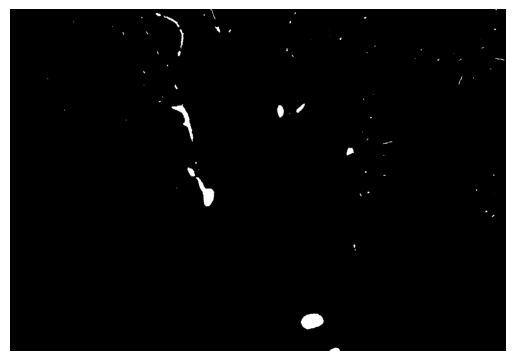

In [11]:
# Load an example image and label
first_image = tifffile.imread(image_files[981])
first_label = tifffile.imread(label_files[981])

# Augment the image and label
# augmented_image, augmented_mask = Augement_image(first_image, first_label)
augmented_zip = Augement_image(first_image, first_label)



# Show the augmented image
# display_image(augmented_image)
# display_image(augmented_mask)

# is_image_tensor = isinstance(augmented_image, np.ndarray)
# is_mask_tensor = isinstance(augmented_mask, np.ndarray)
# print(is_image_tensor, is_mask_tensor)
print(augmented_zip)
display_image(augmented_zip[-1][-1])

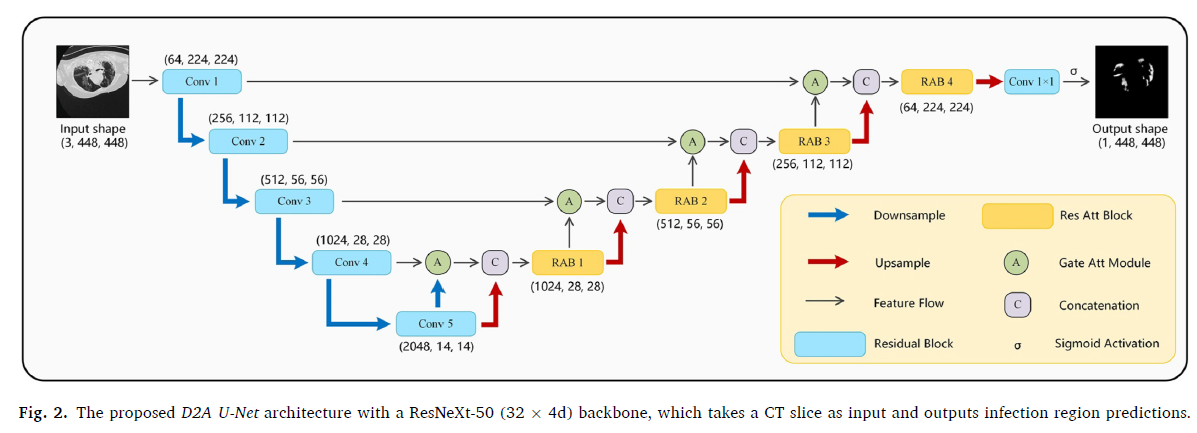

## Model

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        # Defines the first convolution layer with batch normalization
        # kernel_size = (3, 3) means 3x3 filter (common choice in CNNs)
        # padding = 1 means single layer of zeros is added around the image
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=(3, 3), padding=1) 
        self.bn1 = nn.BatchNorm2d(out_channel)

        # Defines the ReLU activation function
        self.relu = nn.ReLU()

        # Defines the second convolution layer with batch normalization
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size=(3, 3), padding=1)
        self.bn2 = nn.BatchNorm2d(out_channel)

    def forward(self, inputs):
        # Applies the first convolution, batch normalization, and ReLU
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        # Applies the second convolution, batch normalization, and ReLU
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

""" Encoder Block """
""" contains a ConvBlock for feature extraction and a max pooling layer to 
    reduce the spatial dimensions of the feature maps, thereby increasing the receptive field of network. """
class EncoderBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        # Instantiates a ConvBlock for encoding and a MaxPooling layer
        self.conv = ConvBlock(in_channel, out_channel)
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), padding=0)

    def forward(self, inputs):
        # Applies ConvBlock and then MaxPooling
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

""" Decoder Block """
""" contains an AttentionBlock, which is applied to the skip connection features.
    The output of the AttentionBlock is concatenated with the upsampled features from the previous layer.
    The concatenated features are then passed through a ConvBlock. """
class DecoderBlock(nn.Module):
    def __init__(self, in_channel, out_channel, use_attention=False):
        super().__init__()
        self.use_attention = use_attention
        if self.use_attention:
            # The attention block operates on the skip connection
            # F_g is the number of feature maps from the upsampled input
            # F_l is the number of feature maps in the skip connection
            # F_int is typically set to be half of F_l for the intermediate features
            self.attention_block = AttentionBlock(F_g=out_channel, F_l=in_channel//2, F_int=in_channel//4)
        
        # Upsampling layer
        self.up = nn.ConvTranspose2d(in_channel//2, out_channel, kernel_size=(2, 2), stride=2, padding=0)
        # Convolution block for the decoder
        self.conv = ConvBlock(in_channel, out_channel)

    def forward(self, inputs, skip):
        # Apply attention to the skip connection first
        if self.use_attention:
            skip = self.attention_block(g=inputs, x=skip)
        
        # Then, upsample the input
        x = self.up(inputs)
        
        # Concatenate the upsampled input with the attention-processed skip connection
        x = torch.cat([x, skip], axis=1)
        
        # Apply the ConvBlock
        x = self.conv(x)
        
        return x

class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        # Defines convolutions for gating signal
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        # Defines convolutions for local features
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        # Combines gating signal and local features to compute attention coefficients
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        # Apply W_g and W_x to the gating signal and local features
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        # Add the transformed g and x, and apply ReLU
        psi = self.relu(g1 + x1)
        # Apply sigmoid to get the attention map
        psi = self.psi(psi)

        # Return the element-wise multiplication of the local features and attention map
        return x * psi

class UNetWithResNext50(nn.Module):
    def __init__(self):
        super(UNetWithResNext50, self).__init__()
        # Load a pre-trained ResNext50 model
        self.base_model = pretrainedmodels.__dict__['se_resnext50_32x4d'](pretrained='imagenet')

        # Define the encoder layers using ResNext50
        self.layer0 = nn.Sequential(
            self.base_model.layer0.conv1,
            self.base_model.layer0.bn1,
            self.base_model.layer0.relu1,
            self.base_model.layer0.pool
        )  # Output channels = 64
        self.layer1 = self.base_model.layer1  # Output channels = 256
        self.layer2 = self.base_model.layer2  # Output channels = 512
        self.layer3 = self.base_model.layer3  # Output channels = 1024

        # Bridge layer between encoder and decoder
        self.b = ConvBlock(1024, 2048)  # Custom bridge layer

        # Define the decoder layers
        self.d1 = DecoderBlock(2048, 1024)
        self.d2 = DecoderBlock(1024, 512)
        self.d3 = DecoderBlock(512, 256)
        self.d4 = DecoderBlock(256, 64)

        # Final classification layer
        self.outputs = nn.Conv2d(in_channels=64, out_channels=CFG.OUT_CHANNEL,
                                 kernel_size=1, padding=0)

    def forward(self, inputs):
        # Pass inputs through each encoder layer, storing skip connections
        skip0 = self.layer0(inputs)
        skip1 = self.layer1(skip0)
        skip2 = self.layer2(skip1)
        skip3 = self.layer3(skip2)

        # Pass through bridge
        bridge = self.b(skip3)

        # Pass through each decoder layer, using skip connections from encoder
        d1 = self.d1(bridge, skip3)
        d2 = self.d2(d1, skip2)
        d3 = self.d3(d2, skip1)
        d4 = self.d4(d3, skip0)

        # Generate final output
        outputs = self.outputs(d4)

        return outputs


# Instantiate the model
model = UNetWithResNext50()